In [1]:
import pandas as pd
import scipy 
import numpy as np
import os
import sys
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import gget
import umap
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import leidenalg
import scanpy as sc
from statsmodels.stats.multitest import multipletests
from numpy import inf

"""WARNING: disabling future warnings"""
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

sys.path.append("/home/cstansbu/.local/lib/python3.9/site-packages/")
import rnalysis
from rnalysis import filtering

/home/cstansbu/.local/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/cstansbu/.local/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/cstansbu/.local/lib/python3.9/site-packages/umap/distances.py:1086: NumbaDeprecationWarning:

In [2]:
# gene names
geneNamePath = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/pipeline_outputs/references/geneNames.csv"
gene = pd.read_csv(geneNamePath)
print(f"{gene.shape=}")

gx = gene[['geneId', 'geneName']].drop_duplicates()
print(f"{gx.shape=}")

geneMap = pd.Series(gx.geneName.values,index=gx.geneId).to_dict()

gene.head()

gene.shape=(262041, 5)
gx.shape=(41407, 2)


,geneId,geneName,transcriptId,transcriptName,geneBiotype
0,ENSG00000160072,ATAD3B,NaN,NaN,protein_coding
1,ENSG00000160072,ATAD3B,ENST00000673477,ATAD3B-206,protein_coding
2,ENSG00000160072,ATAD3B,ENST00000472194,ATAD3B-203,protein_coding
3,ENSG00000160072,ATAD3B,ENST00000378736,ATAD3B-202,protein_coding
4,ENSG00000160072,ATAD3B,ENST00000485748,ATAD3B-205,protein_coding


In [3]:
dir_path = "/nfs/turbo/umms-indikar/shared/projects/HSC/data/pipeline_outputs/htseq/"

barcode_map = {
    'barcode01' : "Control",
    'barcode02' : "Control",
    'barcode03' : "5TF",
    'barcode04' : "10TF",
}

df = []

for f in os.listdir(dir_path):
    barcode = f.split("_")[0]
    fpath = f"{dir_path}{f}"
    
    tmp = pd.read_csv(fpath, sep='\t', header=None)
    tmp.columns = ['gene_id', 'count']
    tmp['barcode'] = barcode
    df.append(tmp)

df = pd.concat(df)
df.head()

,gene_id,count,barcode
0,ENSG00000000003,14,barcode01
1,ENSG00000000005,0,barcode01
2,ENSG00000000419,40,barcode01
3,ENSG00000000457,7,barcode01
4,ENSG00000000460,5,barcode01


In [4]:
def TPM(df, columns, target=1e6, p=1000):
    """A function to compute TPM for each column if a dataframe 
    
    params:
        : df (pd.DataFrame): the data 
        : gf (pd.DataFrame): gene lengths
        : target (float): the normalized sum of reads
        : p (int): the gene length normalization factor, default is kilo3
    """
    tpm = df.copy()
    for c in columns:
        sequence_depth = df[c].sum() / target
        tpm[c] = df[c] / sequence_depth
    return tpm

In [5]:
# aggregate and normalize
df = df.groupby(['gene_id', 'barcode'])['count'].sum().reset_index(drop=False)
df = pd.pivot_table(df, index='gene_id',
                     columns='barcode',
                     values='count').reset_index(drop=False)

# add gene names
df['gene_name'] = df['gene_id'].map(geneMap)

# drop nan genes
df = df[df['gene_name'].notna()].reset_index(drop=True)

# normalize expression assuming full transcript length
df = TPM(df, columns=['barcode01', 'barcode02', 'barcode03', 'barcode04'])
df.head()

barcode,gene_id,barcode01,barcode02,barcode03,barcode04,gene_name
0,ENSG00000000003,17.560596,22.899822,35.903318,48.082721,TSPAN6
1,ENSG00000000005,0.000000,0.000000,0.000000,0.000000,TNMD
2,ENSG00000000419,62.779131,115.086285,122.827141,130.059820,DPM1
3,ENSG00000000457,10.975373,21.725472,17.479247,17.341309,SCYL3
4,ENSG00000000460,7.902268,18.789598,25.037840,20.494275,C1orf112


In [6]:
def getGenes(pdf, cellType, ui_upper=None):
    genes = pdf[pdf['cell type'] == cellType]
    
    if not ui_upper is None:
        genes = genes[genes['ubiquitousness index'] < ui_upper]
    return genes['official gene symbol'].to_list()

pdfPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/panglaodb/pandb.tsv.gz"
pandDf = pd.read_csv(pdfPath, sep="\t")

fb = getGenes(pandDf, 'Fibroblasts')
hp = getGenes(pandDf, 'Hematopoietic stem cells')

print(f"FB genes: {len(fb)}")
print(f"HP genes: {len(hp)}")

FB genes: 179
HP genes: 88


In [7]:
print(fb)

['IL1R1', 'FAP', 'FLI1', 'CELA1', 'LOX', 'PDGFRB', 'P4HA1', 'UCP2', 'CCR2', 'MS4A4C', 'ITGAL', 'EAR2', 'FGR', 'HCK', 'ADGRE4', 'TNFRSF1B', 'PRKCD', 'ENO3', 'CD209A', 'ABI3', 'TREML4', 'LY6I', 'PIP4K2A', 'CD300E', 'SERPINB10', 'CTHRC1', 'TBX18', 'COL15A1', 'GJB2', 'IL34', 'EDN3', 'SLC6A13', 'VTN', 'ITIH5', 'LUM', 'DPT', 'POSTN', 'PENK', 'MMP14', 'COL6A2', 'FABP4', 'ASPN', 'ANGPTL2', 'EFEMP1', 'SCARA5', 'IGFBP3', 'COPZ2', 'DPEP1', 'ADAMTS5', 'COL5A1', 'CD248', 'PI16', 'PAMR1', 'TNXB', 'MMP2', 'COL14A1', 'CLEC3B', 'IGFBP6', 'AKR1C18', 'COL5A2', 'FBN1', 'MFAP5', 'FKBP10', 'PALLD', 'WIF1', 'SNHG18', 'CDH11', 'PTCH1', 'ARAP1', 'FBLN2', 'IGF1', 'PRRX1', 'FKBP7', 'OAF', 'COL6A3', 'CTSK', 'DKK1', 'C1S', 'RARRES2', 'GREM1', 'SPON2', 'TCF21', 'PCSK6', 'COL8A1', 'ENTPD2', 'MMP23', 'CXCL8', 'CXCL3', 'IL6', 'CYP1B1', 'COL13A1', 'ADAMTS10', 'CCL11', 'ADAM33', 'COL4A3', 'COL4A4', 'LAMA2', 'ACKR3', 'CD55', 'FBLN7', 'FIBIN', 'THBS2', 'NOV', 'PTX3', 'MMP3', 'LRRK1', 'HGF', 'FRZB', 'COL12A1', 'COL7A1', 'M

# Individual Gene Analysis

In [8]:
pdf = df.copy()

pdf['is_FB'] = np.where(pdf['gene_name'].isin(fb), True, False)
pdf['is_HSC'] = np.where(pdf['gene_name'].isin(hp), True, False)
print(f"{pdf.shape=}")

control = ['barcode01', 'barcode02']
TF = ['barcode03', 'barcode04']

# welch's test 
scores, pvals = scipy.stats.ttest_ind(pdf[control], 
                                      pdf[TF], 
                                      equal_var=False,
                                      axis=1, )
pdf['scores'] = scores
pdf['pvals'] = pvals

# add adjusted pvalues
# pvals = np.where(np.isnan(pvals), 1, pvals)
# pdf['pvals_adj'] = scipy.stats.false_discovery_control(pvals)

pvals[np.isnan(pvals)] = 1
_, pvals_adj, _, _ = multipletests(pvals, alpha=0.05, method="fdr_bh")
pdf['pvals_adj'] = pvals_adj

pdf['control_mean'] = pdf[control].mean(axis=1)
pdf['TF_mean'] = pdf[TF].mean(axis=1)
pdf['fold_change'] = ((pdf['TF_mean'] + 1) / (pdf['control_mean'] + 1))

pdf = pdf.sort_values(by='fold_change', ascending=False)
pdf.head(20)

pdf.shape=(41407, 8)


barcode,gene_id,barcode01,barcode02,barcode03,barcode04,gene_name,is_FB,is_HSC,scores,pvals,pvals_adj,control_mean,TF_mean,fold_change
5107,ENSG00000120937,0.000000,0.000000,10.865478,15.764827,NPPB,False,False,-5.435478,0.115828,1.0,0.000000,13.315152,14.315152
10238,ENSG00000158825,2.195075,3.523050,40.627439,50.447445,CDA,False,False,-8.613724,0.068495,1.0,2.859062,45.537442,12.059262
3835,ENSG00000111057,11.414387,27.010047,256.047347,201.001539,KRT18,False,False,-7.317015,0.065300,1.0,19.212217,228.524443,11.355728
2506,ENSG00000101353,2.195075,21.138297,122.354729,138.730474,MROH8,False,False,-9.494812,0.011661,1.0,11.666686,130.542601,10.384926
12551,ENSG00000169429,1.317045,4.697399,44.879148,33.894377,CXCL8,True,False,-6.330660,0.073694,1.0,3.007222,39.386762,10.078494
19474,ENSG00000204188,0.878030,0.000000,13.227538,11.823620,GGNBP1,False,False,-14.598400,0.009123,1.0,0.439015,12.525579,9.399193
10732,ENSG00000162595,0.000000,3.523050,30.234373,15.764827,DIRAS3,False,False,-2.852228,0.192925,1.0,1.761525,22.999600,8.690706
27581,ENSG00000232415,0.439015,0.000000,7.086181,11.035379,ELN-AS1,False,False,-4.450091,0.136179,1.0,0.219507,9.060780,8.249872
4170,ENSG00000113396,0.000000,0.000000,6.613769,7.882413,SLC27A6,False,False,-11.426515,0.055573,1.0,0.000000,7.248091,8.248091
12769,ENSG00000170421,22.828775,22.312647,194.161365,160.012990,KRT8,False,False,-9.048678,0.070006,1.0,22.570711,177.087177,7.555444


Text(0.5, 11.166666666666647, '')

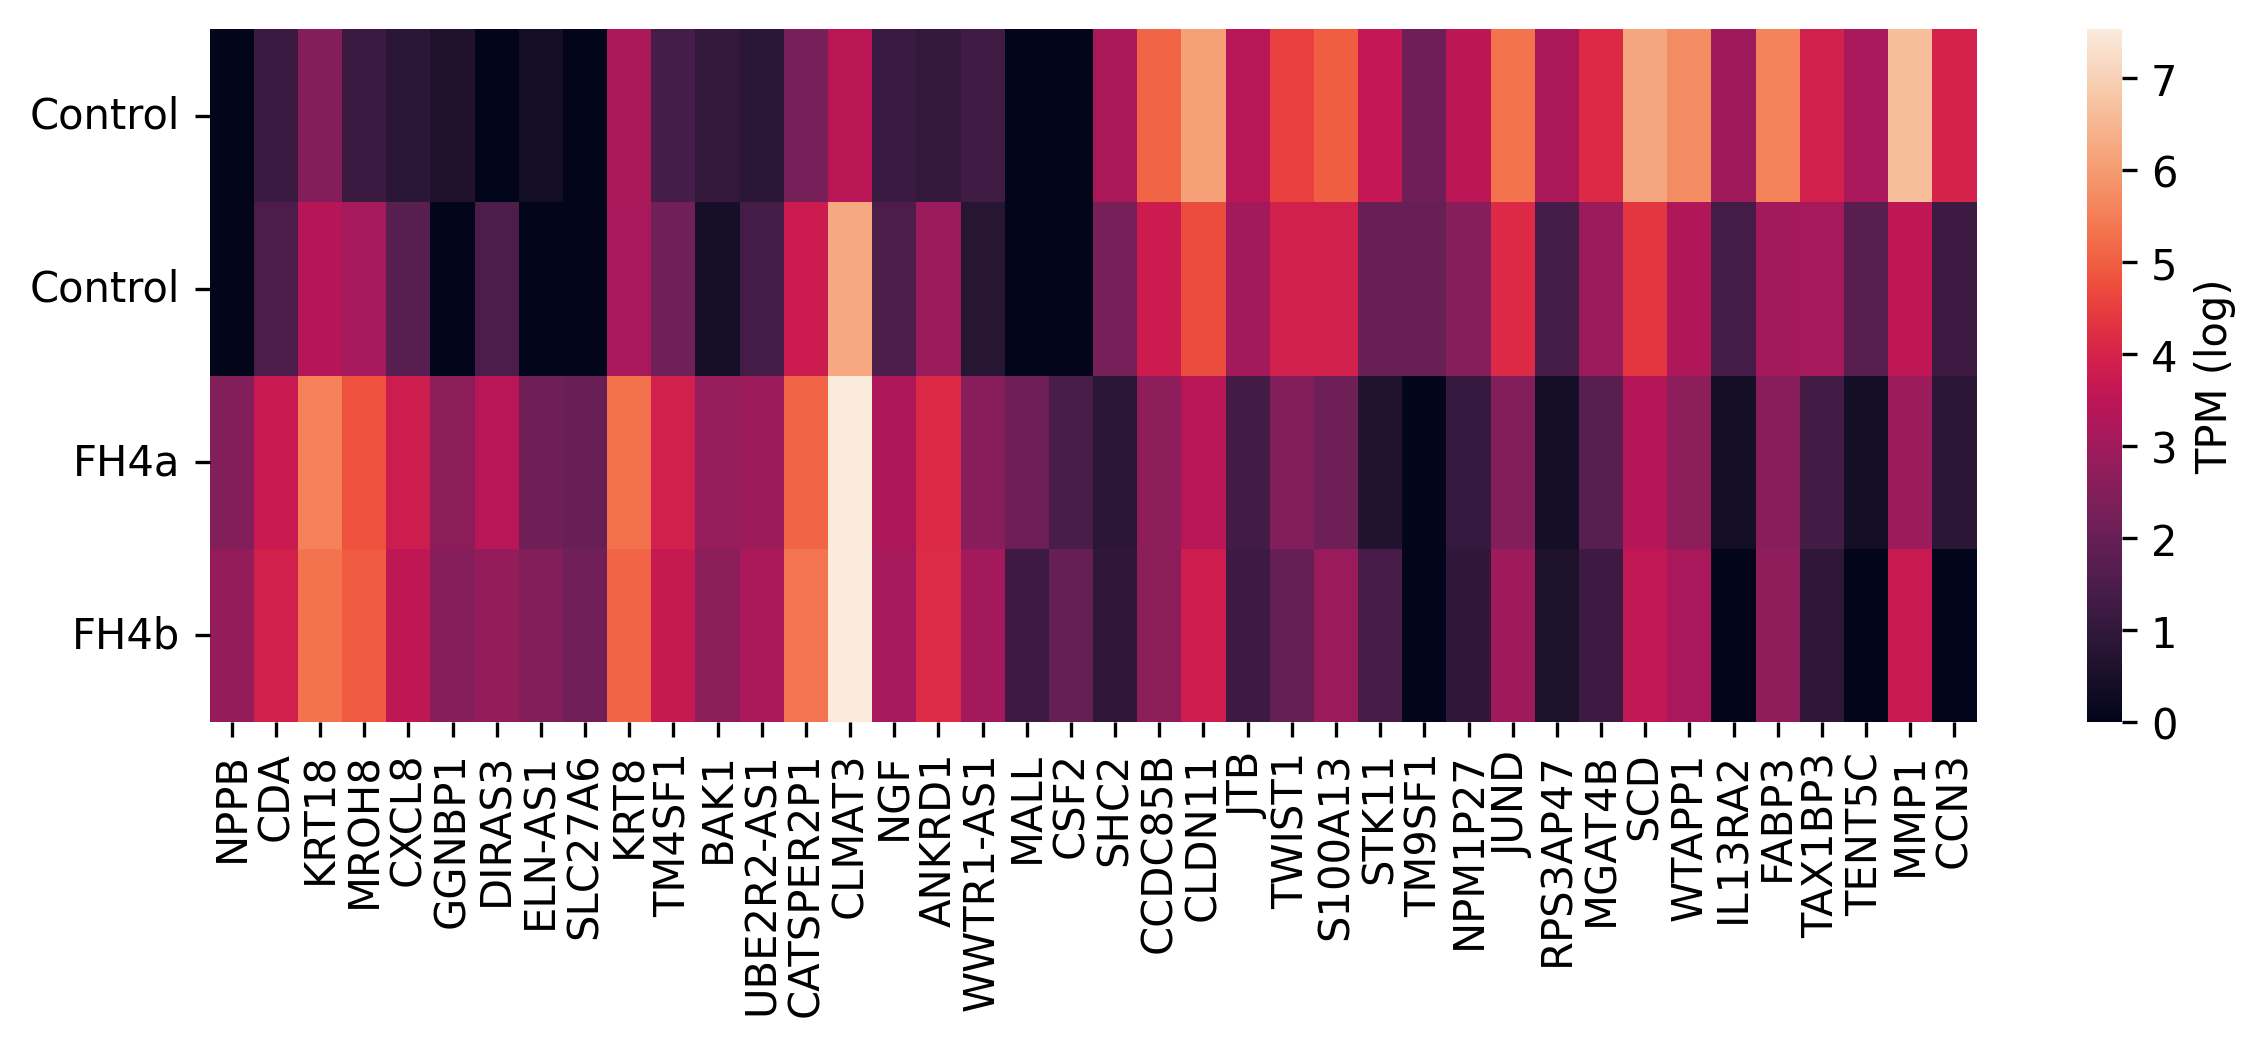

In [9]:
n = 20

mat = pdf.copy()
mat = pd.concat([mat.head(n), mat.tail(n)])

mat = mat.set_index('gene_name')

cols = [
    'barcode01',
    'barcode02',	
    'barcode03',
    'barcode04',
]

mat = mat[cols]
mat.columns = [
    'Control',
    'Control',
    'FH4a',
    'FH4b',
]
mat = np.log1p(mat)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 9.5, 3

sns.heatmap(mat.T,
            cbar_kws={'label' : 'TPM (log)',})
plt.gca().tick_params(axis='y', rotation=0)
plt.ylabel("")
plt.xlabel("")

# HSC Genes

In [10]:
n = 100
print_n = 20

mat = pdf.copy()

db = 'GO_Biological_Process_2021'

edf = gget.enrichr(mat['gene_name'].head(n), database=db)

for idx, row in edf.head(print_n).iterrows():
    print(f"pval={row['adj_p_val']:.3f} {row['path_name']} {row['overlapping_genes']}")

Tue Dec  5 13:54:18 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


pval=0.009 neutrophil chemotaxis (GO:0030593) ['CXCL8', 'SAA1', 'CXCL3', 'CXCL2', 'CCL26']
pval=0.009 granulocyte chemotaxis (GO:0071621) ['CXCL8', 'SAA1', 'CXCL3', 'CXCL2', 'CCL26']
pval=0.009 neutrophil migration (GO:1990266) ['CXCL8', 'SAA1', 'CXCL3', 'CXCL2', 'CCL26']
pval=0.029 chemokine-mediated signaling pathway (GO:0070098) ['CXCL8', 'CXCL3', 'CXCL2', 'CCL26']
pval=0.031 cellular response to chemokine (GO:1990869) ['CXCL8', 'CXCL3', 'CXCL2', 'CCL26']
pval=0.031 cellular response to molecule of bacterial origin (GO:0071219) ['CXCL8', 'SERPINE1', 'ANKRD1', 'CXCL3', 'CXCL2']
pval=0.032 cellular response to lipopolysaccharide (GO:0071222) ['CXCL8', 'SERPINE1', 'ANKRD1', 'CXCL3', 'CXCL2']
pval=0.087 inflammatory response (GO:0006954) ['CXCL8', 'OLR1', 'IKBKG', 'CXCL3', 'CXCL2', 'CCL26']
pval=0.090 response to lipopolysaccharide (GO:0032496) ['CXCL8', 'SERPINE1', 'ANKRD1', 'CXCL3', 'CXCL2']
pval=0.104 serine family amino acid biosynthetic process (GO:0009070) ['PSAT1', 'CTH']
pval=0.

# FB genes

In [11]:
n = 100
print_n = 20

mat = pdf.copy()

db = 'GO_Biological_Process_2021'

edf = gget.enrichr(mat['gene_name'].tail(n), database=db)

for idx, row in edf.head(print_n).iterrows():
    print(f"pval={row['adj_p_val']:.3f} {row['path_name']} {row['overlapping_genes']}")

Tue Dec  5 13:54:19 2023 INFO Performing Enichr analysis using database GO_Biological_Process_2021.


pval=0.012 regulation of macrophage migration (GO:1905521) ['CD81', 'MTUS1', 'EMILIN1']
pval=0.050 regulation of cell cycle (GO:0051726) ['STK11', 'JUND', 'RGCC', 'BIN1', 'CSNK2A3', 'DAPK3', 'PRDM11', 'JUNB']
pval=0.089 negative regulation of cell cycle phase transition (GO:1901988) ['RGCC', 'ZFP36L2']
pval=0.089 regulation of extracellular matrix assembly (GO:1901201) ['RGCC', 'EMILIN1']
pval=0.089 negative regulation of cellular process (GO:0048523) ['STK11', 'FABP3', 'RGCC', 'CCDC85B', 'CCN5', 'ZNF503', 'CCN3', 'EMILIN1', 'ANP32B', 'PRDM11']
pval=0.103 embryonic limb morphogenesis (GO:0030326) ['TWIST1', 'HOXA11', 'TBX2']
pval=0.103 positive regulation of extracellular matrix assembly (GO:1901203) ['RGCC', 'EMILIN1']
pval=0.219 regulation of nuclear-transcribed mRNA catabolic process, deadenylation-dependent decay (GO:1900151) ['TNRC6C', 'ZFP36L2']
pval=0.219 positive regulation of nuclear-transcribed mRNA catabolic process, deadenylation-dependent decay (GO:1900153) ['TNRC6C', 'ZFP

# Transcription Factors

Tue Dec  5 13:54:20 2023 INFO Performing Enichr analysis using database TRRUST_Transcription_Factors_2019.


,rank,path_name,p_val,z_score,combined_score,overlapping_genes,adj_p_val,database,p_name,logp
0,1,RELA human,3.225935e-07,8.357613,124.920184,"[NPPB, CSF2, CXCL8, MMP1, SERPINE1, ALOX5AP, S...",0.000045,TRRUST_Transcription_Factors_2019,RELA,4.345216
1,2,NFKB1 human,2.854987e-06,7.435343,94.922886,"[NPPB, CSF2, CXCL8, MMP1, SERPINE1, ALOX5AP, S...",0.000200,TRRUST_Transcription_Factors_2019,NFKB1,3.699298
2,3,STAT3 human,7.237344e-06,11.019912,130.434508,"[DIRAS3, STK11, CXCL8, MMP1, SAA1, TWIST1, JUNB]",0.000338,TRRUST_Transcription_Factors_2019,STAT3,3.471414
4,5,ETS2 human,5.414211e-04,21.191966,159.391414,"[CXCL8, CSF2, MMP1]",0.015160,TRRUST_Transcription_Factors_2019,ETS2,1.819307
5,6,RBMX human,6.795552e-04,67.666667,493.565548,"[JUND, JUNB]",0.015856,TRRUST_Transcription_Factors_2019,RBMX,1.799798
7,8,ING4 human,2.490834e-03,31.219780,187.166877,"[CXCL8, NGF]",0.037371,TRRUST_Transcription_Factors_2019,ING4,1.427464
8,9,BRCA1 human,2.918096e-03,11.366552,66.344564,"[KRT18, FST, CTSD]",0.037371,TRRUST_Transcription_Factors_2019,BRCA1,1.427464
9,10,FOS human,2.918096e-03,11.366552,66.344564,"[CXCL8, MMP1, NGF]",0.037371,TRRUST_Transcription_Factors_2019,FOS,1.427464
10,11,CEBPB human,3.376074e-03,10.766685,61.273653,"[CXCL8, MMP1, SAA1]",0.037371,TRRUST_Transcription_Factors_2019,CEBPB,1.427464
11,12,DDIT3 human,3.594237e-03,25.362245,142.749456,"[CXCL8, ANKRD1]",0.037371,TRRUST_Transcription_Factors_2019,DDIT3,1.427464


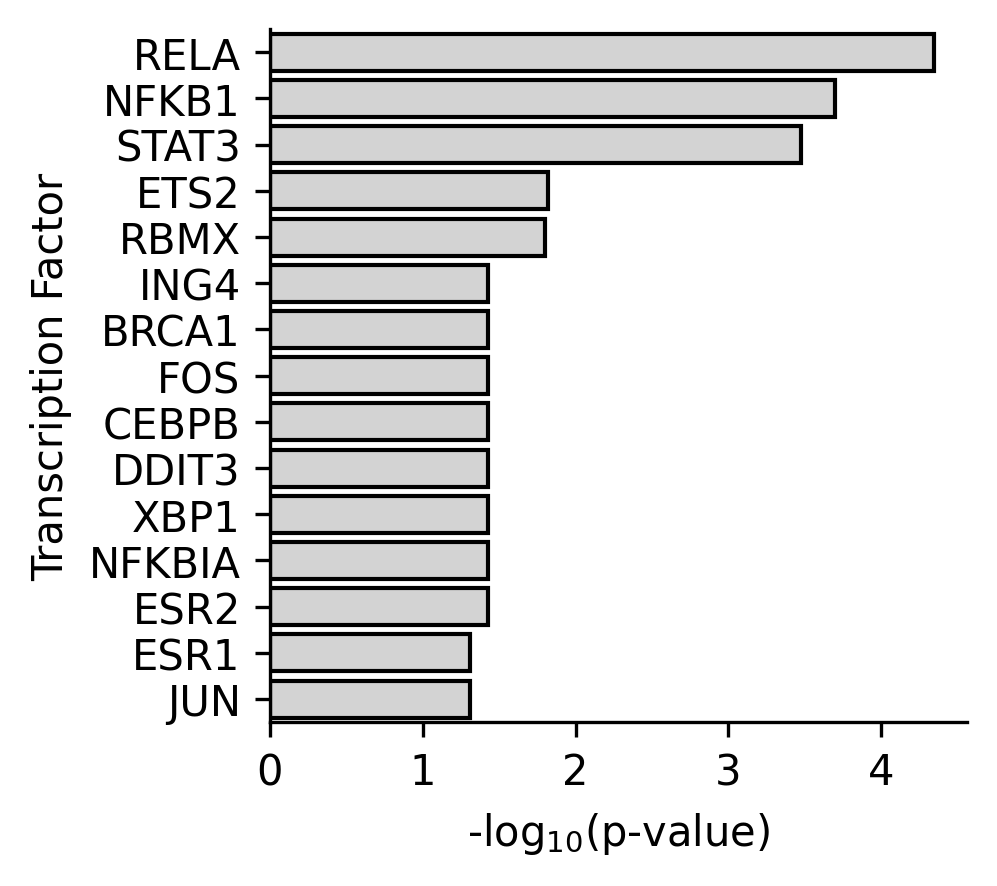

In [12]:
alpha = 0.05
n = 50
mat = pdf.copy()

# filter genes
mat = mat[~mat['gene_name'].str.endswith("-AS1")]
mat = mat[~mat['gene_name'].str.endswith("-AS")]
mat = mat[~mat['gene_name'].str.endswith("-DT")]

mat = pd.concat([mat.head(n), mat.tail(n)])

# db = 'TRANSFAC_and_JASPAR_PWMs'
# db = 'Rummagene_transcription_factors'
db = 'TRRUST_Transcription_Factors_2019'
edf = gget.enrichr(mat['gene_name'], database=db)
edf = edf[edf['path_name'].str.contains('human')]

edf['p_name'] = edf['path_name'].apply(lambda x: x.split(" ")[0])

edf = edf[edf['adj_p_val'] < alpha]

edf['logp'] = -np.log10(edf['adj_p_val'])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
sns.barplot(data=edf, 
            x='logp',
            y='p_name',
            ec='k',
            color='lightgrey')

plt.ylabel("Transcription Factor")
plt.xlabel(r"-log$_{10}$(p-value)")
sns.despine()


edf.head(10)

# Individual gene plots

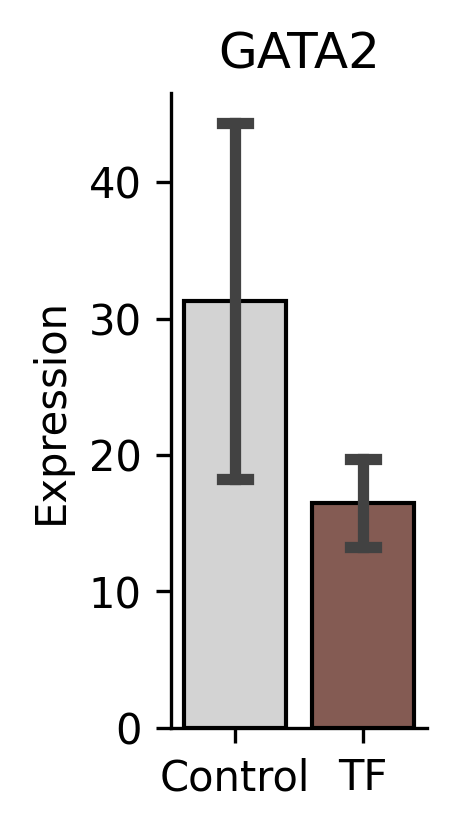

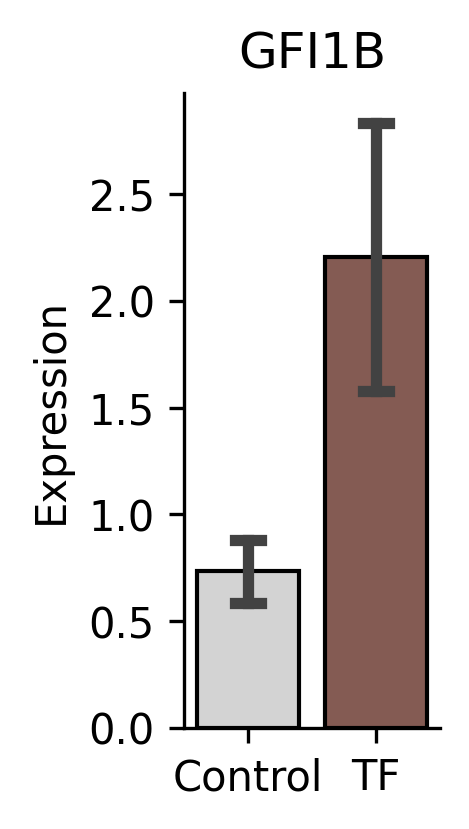

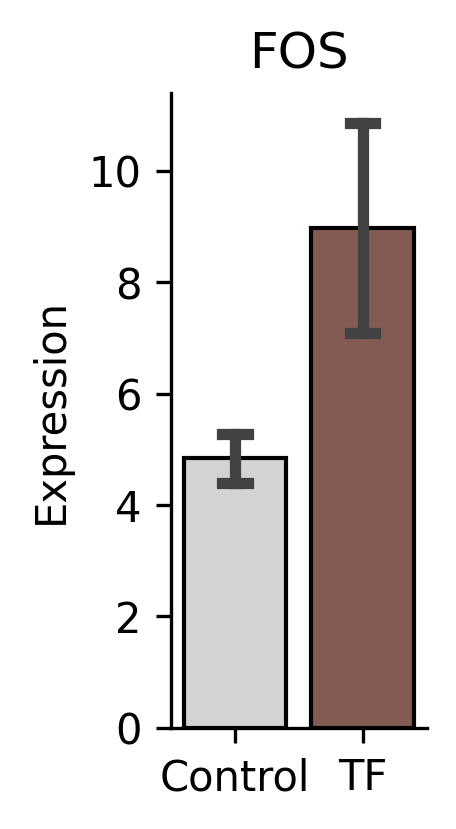

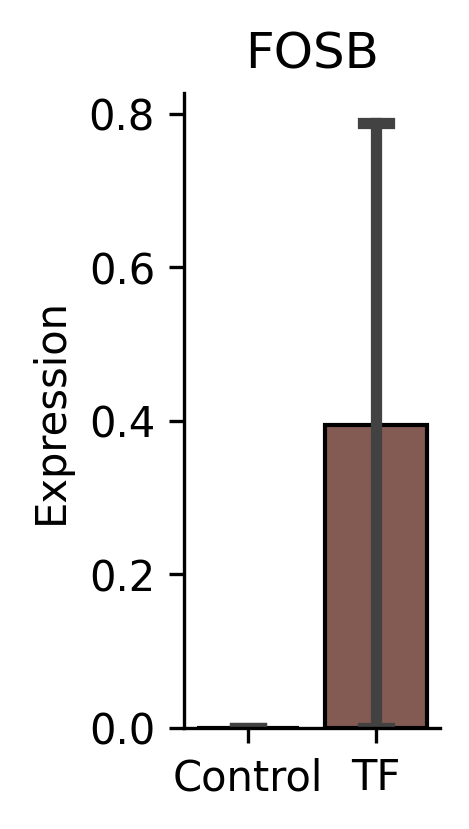

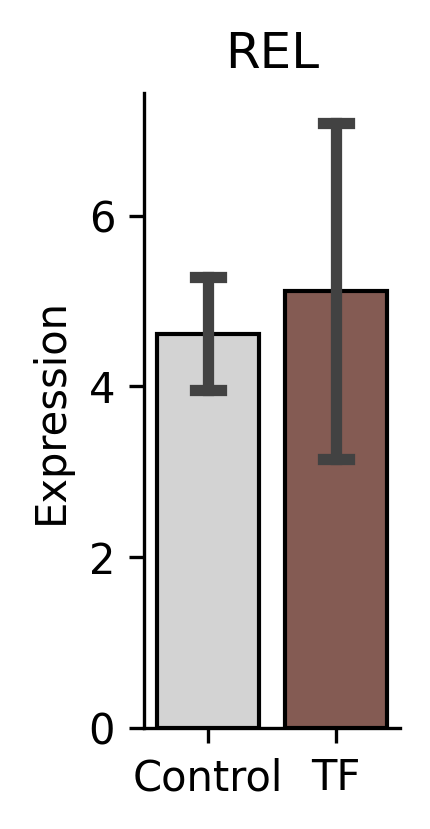

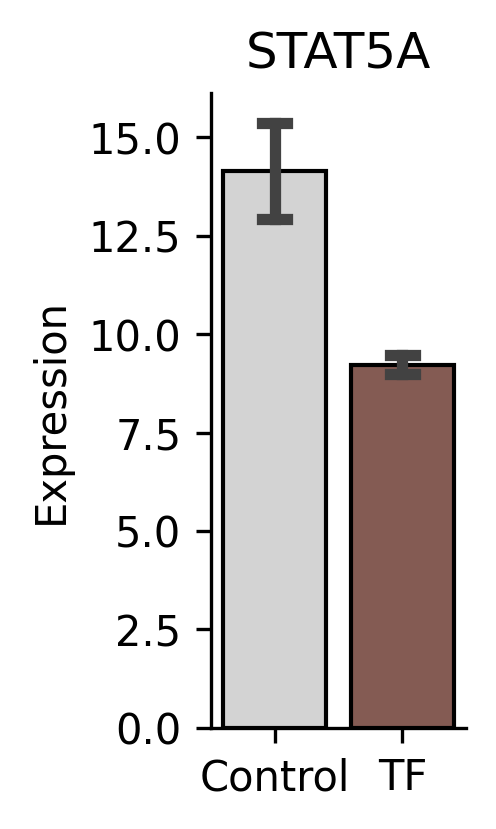

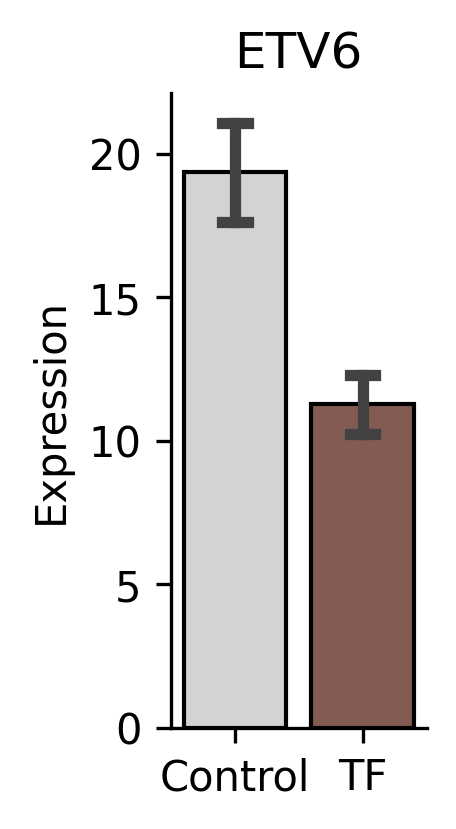

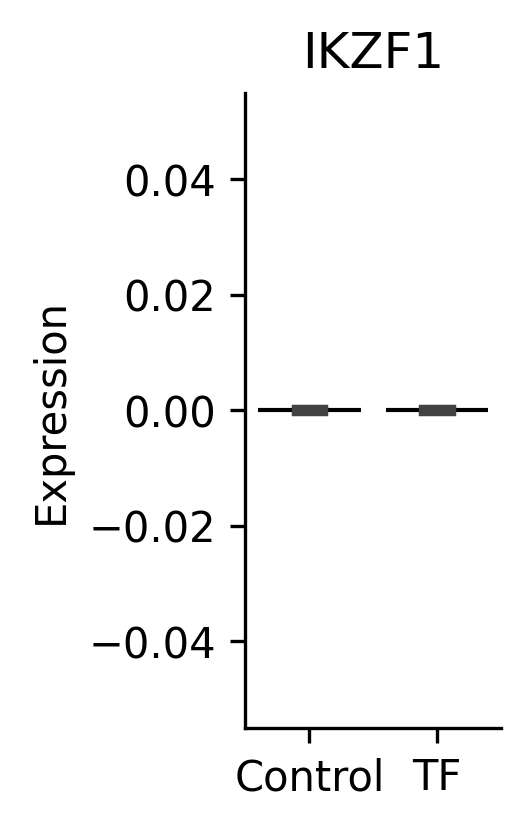

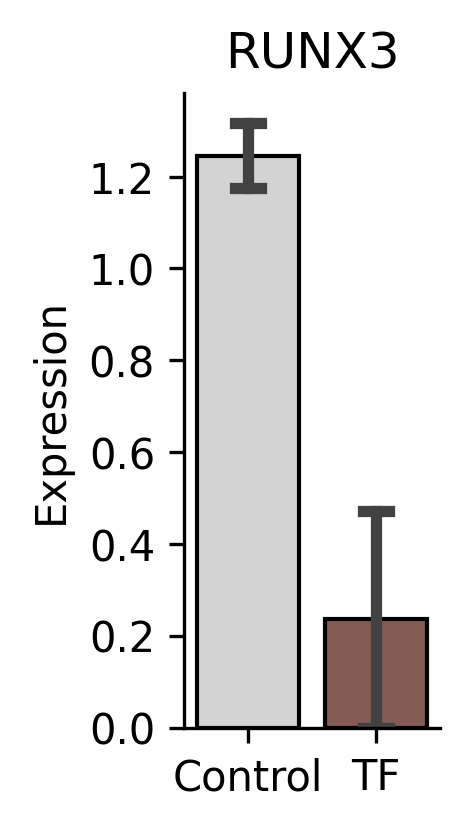

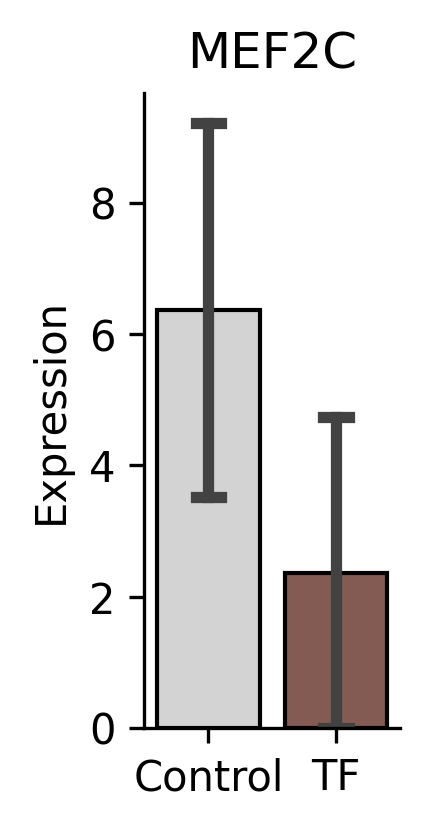

In [13]:
pdf = df.copy()
color = 'C5'
genes = ['GATA2', 'GFI1B', 'FOS', 'FOSB', 'REL', 'STAT5A', 'ETV6', 'IKZF1', 'RUNX3', 'MEF2C']
# genes = ['CD34', 'TEK', 'ABCG2', 'SPN','PROCR' ,]
# genes = ['FLI1', 'CELA1', 'PDGFRB', 'FGR', 'TNFRSF1B', 'COL15A1', 'MMP14', 'FIBIN',  ]
# genes = ['SCL' ]
pdf = pd.melt(pdf, id_vars=['gene_id', 'gene_name'],).reset_index(drop=True)
condition_map = {
    'barcode01' : "Control",
    'barcode02' : "Control",
    'barcode03' : "TF",
    'barcode04' : "TF",
}

pdf['Experiment'] = pdf['barcode'].map(barcode_map)
pdf['Condition'] = pdf['barcode'].map(condition_map)

for gene in genes:

    pdx = pdf[pdf['gene_name'] == gene]
    
    
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['figure.figsize'] = 1.1 , 2.75
    
    sns.barplot(data=pdx,
                x='Condition',
                hue='Condition',
                y='value',
                dodge=False,
                ec='k',
                capsize=0.2,
                # err_kws={'c' : 'k', 'lw' : 1.2},
                palette=['lightgrey', color],
               )

    plt.title(f'{gene}')
    plt.ylabel(f'Expression')
    plt.xlabel(f'')
    plt.gca().legend().remove()
    sns.despine()
    plt.show()


In [14]:
# break

# Marker Gene Expression Analysis

,gene_id,gene_name,barcode,value,Experiment,Condition
0,ENSG00000000003,TSPAN6,barcode01,17.560596,Control,C
2,ENSG00000000419,DPM1,barcode01,62.779131,Control,C
3,ENSG00000000457,SCYL3,barcode01,10.975373,Control,C
4,ENSG00000000460,C1orf112,barcode01,7.902268,Control,C
5,ENSG00000000938,FGR,barcode01,0.439015,Control,C


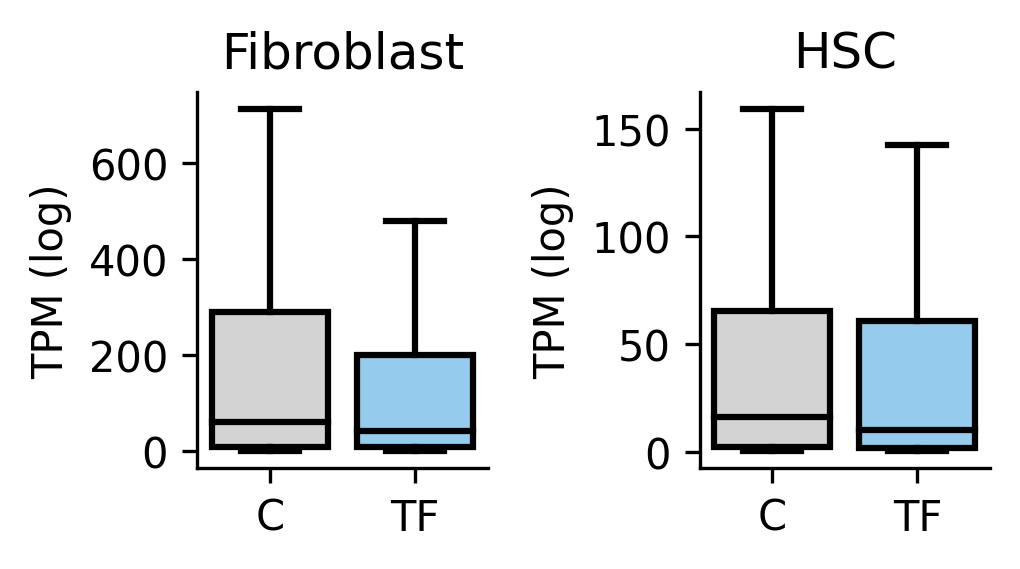

In [72]:
pdf = df.copy()
pdf = pd.melt(pdf, id_vars=['gene_id', 'gene_name'],).reset_index(drop=True)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3.5, 2
fig, axs = plt.subplots(1, 2)


condition_map = {
    'barcode01' : "C",
    'barcode02' : "C",
    'barcode03' : "TF",
    'barcode04' : "TF",
}

pdf['Experiment'] = pdf['barcode'].map(barcode_map)
pdf['Condition'] = pdf['barcode'].map(condition_map)
pdf = pdf[pdf['value'] > 0]

colors = ['lightgrey', 'lightskyblue', 'C0',]
box_props = {
    'boxprops' : {'edgecolor' : 'k'},
    'medianprops' : {'color' : 'k'},
    'whiskerprops' : {'color' : 'k'},
    'capprops' : {'color' : 'k'}
}
sns.boxplot(data=pdf[pdf['gene_name'].isin(fb)], 
            x='Condition',
            y='value',
            showfliers=False,
            palette=colors,
            ax=axs[0],
            **box_props)

# sns.stripplot(data=pdf[pdf['gene_name'].isin(fb)], 
#               x="Experiment",
#               y="value",
#               s=1.5,
#               c='k',
#               ec='none',
#               alpha=0.5,
#               ax=axs[0])

axs[0].set_xlabel("")
axs[0].set_ylabel("TPM (log)")
# axs[0].set_yscale("log")
axs[0].set_title("Fibroblast")


sns.boxplot(data=pdf[pdf['gene_name'].isin(hp)], 
            x='Condition',
            y='value',
            showfliers=False,
            palette=colors,
            ax=axs[1],
            **box_props)

# sns.stripplot(data=pdf[pdf['gene_name'].isin(hp)], 
#               x="Experiment",
#               y="value",
#               s=1.5,
#               c='k',
#               ec='none',
#               alpha=0.5,
#               ax=axs[1])


axs[1].set_title("HSC")
axs[1].set_xlabel("")
axs[1].set_ylabel("TPM (log)")
# axs[1].set_yscale("log")

plt.tight_layout()
sns.despine()
pdf.head()

,gene_id,gene_name,barcode,value,Experiment,Condition,gene_set
0,ENSG00000000938,FGR,barcode01,0.439015,Control,C,Fibroblast
1,ENSG00000005102,MEOX1,barcode01,0.439015,Control,C,Fibroblast
2,ENSG00000005243,COPZ2,barcode01,73.754504,Control,C,Fibroblast
3,ENSG00000005961,ITGA2B,barcode01,0.439015,Control,C,HSC
4,ENSG00000008394,MGST1,barcode01,329.261177,Control,C,HSC


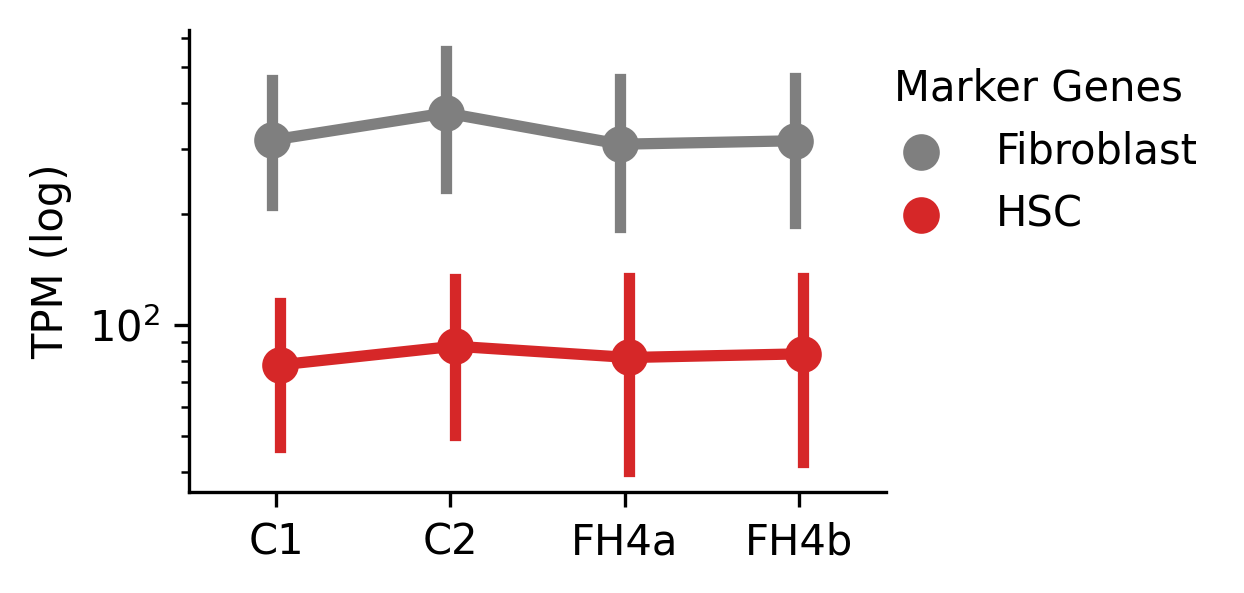

In [71]:
pdf = df.copy()
gene_set = 'HSC'
pdf = pd.melt(pdf, id_vars=['gene_id', 'gene_name'],).reset_index(drop=True)

condition_map = {
    'barcode01' : "C",
    'barcode02' : "C",
    'barcode03' : "TF",
    'barcode04' : "TF",
}

pdf['Experiment'] = pdf['barcode'].map(barcode_map)
pdf['Condition'] = pdf['barcode'].map(condition_map)
pdf = pdf[pdf['value'] > 0]

pdf['gene_set'] = np.where(pdf['gene_name'].isin(fb), 'Fibroblast', 'NA')
pdf['gene_set'] = np.where(pdf['gene_name'].isin(hp), 'HSC', pdf['gene_set'])

pdf = pdf[pdf['gene_set'] != 'NA'].reset_index(drop=True)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 2

sns.pointplot(data=pdf, 
            x='barcode',
            y='value', 
            hue='gene_set',
            palette=['C7', 'C3'],
            dodge=True,)

plt.gca().set_xticklabels(['C1', 'C2', 'FH4a', 'FH4b'])
plt.yscale('log')
plt.xlabel('')
plt.ylabel('TPM (log)')
sns.despine()

sns.move_legend(plt.gca(), 
                loc='upper right',
                title='Marker Genes',
                frameon=False,
                bbox_to_anchor=(1.5, 1))
pdf.head()

In [17]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# break

In [ ]:
pdf = df.copy()

pdf = pd.melt(pdf, id_vars=['gene_id', 'gene_name'],).reset_index(drop=True)
pdf['Experiment'] = pdf['barcode'].map(barcode_map)
pdf = pdf.groupby(['Experiment', 'gene_name'])['value'].mean().reset_index(drop=False)

res = []

for celltype, genelist in zip(['Fibroblasts', 'HSC'],[fb, hp]):
    gx = pdf[pdf['gene_name'].isin(genelist)]

    for t in np.linspace(0, 1000, 15):
        x = gx[gx['value'] > t]
        x = x.groupby('Experiment')['gene_name'].count().reset_index(drop=False)
        x['threshold'] = t
        x['celltype'] = celltype
        res.append(x)

res = pd.concat(res)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 2.75
fig, axs = plt.subplots(1, 2)

sns.lineplot(data=res[res['celltype'] == 'Fibroblasts'],
             x='threshold',
             y='gene_name',
             hue='Experiment',
             palette=['C0', 'lightblue', 'r'],
             ax=axs[0])

axs[0].set_yscale('log')
axs[0].set_ylabel('n Genes')
axs[0].set_xlabel('Expression (TPM)')
axs[0].set_title('Fibroblast')
axs[0].legend().remove()

sns.lineplot(data=res[res['celltype'] == 'HSC'],
             x='threshold',
             y='gene_name',
             hue='Experiment',
             palette=['C0', 'lightblue', 'r'],
             ax=axs[1])

axs[1].set_yscale('log')
axs[1].set_xlabel('Expression (TPM)')
axs[1].set_ylabel('')
axs[1].set_title('HSC')
plt.tight_layout()
sns.despine()

# Distribution of Expression

In [ ]:
pdf = df.copy()
pdf = pd.melt(pdf, id_vars=['gene_id', 'gene_name'],).reset_index(drop=True)
condition_map = {
    'barcode01' : "Control",
    'barcode02' : "Control",
    'barcode03' : "TF",
    'barcode04' : "TF",
}

pdf['Experiment'] = pdf['barcode'].map(barcode_map)
pdf['Condition'] = pdf['barcode'].map(condition_map)

pdf = pd.pivot_table(pdf, index='gene_name',
                     columns='Condition',
                     values='value',
                     aggfunc='mean')

cols = pdf.columns
pdf = pdf.reset_index(drop=False)

for c in cols:
    fold_col = f"{c}_FOLD"
    log_fold_col = f"{c}_LOG_FOLD"
    other_cols = cols[~cols.isin([c])].to_list()
    print(c, other_cols)

    # add fold changes and log fold changes
    pdf[fold_col] = (pdf[c] + 1)  / (pdf[other_cols].mean(axis=1) + 1) 
    pdf[log_fold_col] = np.log1p(pdf[fold_col])


pdf.head()

In [ ]:
query_n = 50

cols = [
    'TF_FOLD',
    'Control_FOLD',
]

for c in cols:
    print(f"========= {c} =========")
    tmp = pdf.sort_values(by=c, ascending=False)
    print(tmp[['gene_name', 'TF','Control', c]].head(20))

    # # GSEA
    # query = tmp['gene_name'].to_list()
    # edf = gget.enrichr(query[:query_n], database='ontology')
    # print(edf[['path_name', 'adj_p_val']].head())
    
    print()

In [ ]:
query_n = 50

cols = [
    'TF_FOLD',
    'Control_FOLD',
]

for c in cols:
    print(f"========= {c} =========")
    tmp = pdf.sort_values(by=c, ascending=False)

     # GSEA
    query = tmp['gene_name'].to_list()
    edf = gget.enrichr(query[:query_n], database='TRANSFAC_and_JASPAR_PWMs')
    print(edf[['path_name', 'adj_p_val']].head())
    print()

In [ ]:
pdf = df.copy()

pdf = pd.melt(pdf, id_vars=['gene_id', 'gene_name'],).reset_index(drop=True)
pdf['Experiment'] = pdf['barcode'].map(barcode_map)

pdf = pdf[pdf['gene_name'].isin(fb)]


plt.rcParams['figure.dpi'] = 300

g = sns.FacetGrid(pdf, 
                  row="Experiment", 
                  hue="Experiment", 
                  aspect=3, 
                  height=0.8, 
                  palette=['r', 'lightblue', 'C0',],)

g.map(sns.histplot, 
      "value",
      bins=np.linspace(0, 1000, 35),
      alpha=0.6,)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, 1.3, 
            label, 
            fontweight="bold", 
            color=color,
            ha="left",
            va="center", 
            transform=ax.transAxes)

g.map(label, "Experiment")
g.set_titles("")
g.set(yscale='log')
g.set(yticks=[], ylabel="",)
g.set(xlabel="Expression (TPM)")
g.despine(left=True)
plt.suptitle("Fibroblast", x=0.6, y=1.05)

In [ ]:
pdf = df.copy()

pdf = pd.melt(pdf, id_vars=['gene_id', 'gene_name'],).reset_index(drop=True)
pdf['Experiment'] = pdf['barcode'].map(barcode_map)

pdf = pdf[pdf['gene_name'].isin(hp)]


plt.rcParams['figure.dpi'] = 300

g = sns.FacetGrid(pdf, 
                  row="Experiment", 
                  hue="Experiment", 
                  aspect=3, 
                  height=0.8, 
                  palette=['r', 'lightblue', 'C0',])

g.map(sns.histplot, 
      "value",
      bins=np.linspace(0, 1000, 35),
      alpha=0.6,)

# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, 1.3, 
            label, 
            fontweight="bold", 
            color=color,
            ha="left",
            va="center", 
            transform=ax.transAxes)

g.map(label, "Experiment")
g.set_titles("")
g.set(yscale='log')
g.set(yticks=[], ylabel="",)
g.set(xlabel="Expression (TPM)")
g.despine(left=True)

plt.suptitle("HSC", x=0.6, y=1.05)

# Greatest differences

In [ ]:
# the most different genes
logfoldchange_threshold = 2
pdf = df.copy()
print(f"{pdf.shape=}")
pdf['Control'] = pdf[['barcode01', 'barcode02']].mean(axis=1)
pdf['TF'] = pdf[['barcode03', 'barcode04']].mean(axis=1)
pdf['foldchange'] = (pdf['TF'] + 1) / (pdf['Control'] + 1) 
pdf['logfoldchange'] = np.log2(pdf['foldchange'])

pdf = pdf.sort_values(by='logfoldchange')
pdf = pdf[pdf['logfoldchange'] != 0] # zero expression 
print(f"{pdf.shape=}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 3

sns.histplot(data=pdf, 
             x='logfoldchange', 
             bins=100)

plt.axvline(x=logfoldchange_threshold, lw=1, c='k', ls=":")
plt.axvline(x=-logfoldchange_threshold, lw=1, c='k', ls=":")

plt.ylabel("N Genes")
plt.xlabel("Fold Change (log2)")
sns.despine()
pdf.head()


In [ ]:
n = 20

pdf2 = pdf[~pdf['gene_name'].str.endswith("-AS1")]
pdf2 = pdf2[~pdf2['gene_name'].str.endswith("-AS")]
pdf2 = pdf2[~pdf2['gene_name'].str.endswith("-DT")]


upper = pdf2[pdf2['logfoldchange'] > logfoldchange_threshold]
print(f"{upper.shape=}")
upper = upper.head(n)
# print(upper)
upper = upper['gene_name'].to_list()

lower = pdf2[pdf2['logfoldchange'] < logfoldchange_threshold]
print(f"{lower.shape=}")
lower = lower.head(n)
# print(lower)
lower = lower['gene_name'].to_list()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 5, 5
fig, axs = plt.subplots(2, 1)

for i, (cond, gene_list) in enumerate(zip(['TF', 'Control'], [upper, lower])):

    # reshape
    pdx = pdf2[pdf2['gene_name'].isin(gene_list)]
    pdx = pd.melt(pdx, id_vars=['gene_id', 'gene_name'],).reset_index(drop=True)
    pdx['Condition'] = pdx['barcode'].map(condition_map)


    sns.barplot(data=pdx, 
                x='gene_name',
                y='value',
                hue='Condition',
                palette=['r', 'C0'],
                ec='k',
                ax=axs[i],
                errwidth=1.5,
                alpha=0.8,
                saturation=0.8)

    axs[i].tick_params(axis='x', rotation=90)
    axs[i].set_yscale('log')
    axs[i].set_ylabel('Expression (TPM)')
    axs[i].set_xlabel('')
    
    if i != 0:
        axs[i].legend().remove()
    else:
        sns.move_legend(axs[i], 
                loc='upper right',
                frameon=False,
                title="",
                bbox_to_anchor=(1.4, 1.1)
               )

sns.despine()
plt.tight_layout()

In [ ]:
n_query = 30
alpha = 0.05
db = 'ontology'
db = 'TRRUST_Transcription_Factors_2019'
# db = "TRANSFAC_and_JASPAR_PWMs"

pdf2 = pdf[~pdf['gene_name'].str.endswith("-AS1")]
pdf2 = pdf2[~pdf2['gene_name'].str.endswith("-AS")]
pdf2 = pdf2[~pdf2['gene_name'].str.endswith("-DT")]


# up regulated in TF
query = pdf2['gene_name'].tail(n_query).to_list()
edf = gget.enrichr(query, database=db)
edf = edf[edf['path_name'].str.endswith('human')]
print(edf[['path_name', 'adj_p_val', 'overlapping_genes']].head(10))


edf['p_name'] = edf['path_name'].apply(lambda x: x.split(" ")[0])

edf = edf[edf['adj_p_val'] < alpha]

edf['logp'] = -np.log10(edf['adj_p_val'])

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3
sns.barplot(data=edf, 
            x='logp',
            y='p_name',
            ec='k',
            color='lightgrey')

plt.ylabel("Transcription Factor")
plt.xlabel(r"-log$_{10}$(p-value)")
sns.despine()



# pdf.head()

# Heatmaps

In [ ]:
pdf = df.copy()
pdf = pd.melt(pdf, id_vars=['gene_id', 'gene_name'],).reset_index(drop=True)
pdf['Experiment'] = pdf['barcode'].map(barcode_map)

res = []

for celltype, genelist in zip(['Fibroblasts', 'HSC'],[fb, hp]):
    ct = pdf[pdf['gene_name'].isin(genelist)]
    

    print(ct.head())
    break

In [ ]:
break

# clustering

In [ ]:
# cluster genes
pdf = df.copy()
print(f"{pdf.shape=}")

features  = [
    'barcode01',	
    'barcode02',	
    'barcode03',	
    'barcode04',
]

# drop zero-expressing genes
rowSums = pdf[features].sum(axis=1)
keep = (rowSums > 1)
pdf = pdf[keep]

# drop low-variability genes
rowstd = pdf[features].std(axis=1)
keep = (rowstd > 2)
pdf = pdf[keep]
print(f"{pdf.shape=}")


"""UMAP embedding for plotting """
n_neighbors = 11
min_dist = 0.2
spread = 1.0
mappy = umap.UMAP(n_components=2, 
                  n_neighbors=n_neighbors,
                  min_dist=min_dist,
                  spread=spread)

# edf = mappy.fit_transform(pdf[features].sample(1000))
edf = mappy.fit_transform(pdf[features])
edf = pd.DataFrame(edf, columns=['UMAP 1', 'UMAP 2'])
print(f"{edf.shape=}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 3

sns.scatterplot(data=edf, 
                x='UMAP 1',
                y='UMAP 2',
                alpha=0.8,
                c='grey',
                ec='none',
                s=3,)

In [ ]:
def cluster(X, knn=11, resolution=1.0):
    """A function to cluster a data matrix """
    # transform to adjacency graph 
    nbrs = NearestNeighbors(n_neighbors=knn, algorithm='ball_tree').fit(X)
    g = nbrs.kneighbors_graph(X).toarray()
    g = sc._utils.get_igraph_from_adjacency(g, directed=False)
    
    partition_type = leidenalg.RBConfigurationVertexPartition
    part = leidenalg.find_partition(g, partition_type)
    groups = np.array(part.membership)

    return groups


""" Cluster the data: Lieden clustering"""
edf['cluster'] = cluster(pdf[features], knn=1007, resolution=0.001)
edf['cluster'] = edf['cluster'].astype(float) + 1

print(edf['cluster'].value_counts(normalize=True))

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 4

sns.scatterplot(data=edf, 
                x='UMAP 1',
                y='UMAP 2',
                s=5,
                hue='cluster',
                palette='viridis',
                ec='None',
                lw=1,
                alpha=0.9)

sns.move_legend(plt.gca(), 
                loc='upper left',
                bbox_to_anchor=(1.1, 1))

plt.xticks([])
plt.yticks([])
sns.despine()

# Random Plots

In [ ]:
pdf = df.copy()

goi = fb + hp

pdf = pdf[pdf['gene_name'].isin(fb)]
pdf = pd.melt(pdf, id_vars=['gene_id', 'gene_name'],).reset_index(drop=True)
pdf['Experiment'] = pdf['barcode'].map(barcode_map)

pdf['mean_coconut'] = pdf.groupby(['gene_name', 'Experiment'])['value'].transform('mean')
pdf = pdf.sort_values(by=['Experiment', 'mean_coconut'], ascending=[False, False])

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3

sns.lineplot(data=pdf[pdf['Experiment'] == 'Control'], 
                x='gene_name',
                y='value',
                alpha=0.5,
                hue='Experiment',
                zorder=1)


sns.scatterplot(data=pdf[pdf['Experiment'] != 'Control'], 
                x='gene_name',
                y='value',
                s=5,
                ec='k',
                hue='Experiment',
                palette='plasma',
                zorder=2)


plt.yscale('log')
plt.ylabel("Expression")
plt.xlabel("FB Gene")
plt.tick_params(
    axis='x',         
    bottom=True,      
    labelbottom=False)
sns.despine()


pdf.head()

In [ ]:
pdf = df.copy()

goi = fb + hp

pdf = pdf[pdf['gene_name'].isin(fb)]
pdf = pd.melt(pdf, id_vars=['gene_id', 'gene_name'],).reset_index(drop=True)
pdf['Experiment'] = pdf['barcode'].map(barcode_map)

pdf['mean_coconut'] = pdf.groupby(['gene_name', 'Experiment'])['value'].transform('mean')
pdf = pdf.sort_values(by=['Experiment', 'mean_coconut'], ascending=[False, False])

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 3

sns.lineplot(data=pdf[pdf['Experiment'] == 'Control'], 
                x='gene_name',
                y='value',
                alpha=0.5,
                hue='Experiment',
                zorder=1)


sns.scatterplot(data=pdf[pdf['Experiment'] != 'Control'], 
                x='gene_name',
                y='value',
                s=5,
                ec='k',
                hue='Experiment',
                palette='plasma',
                zorder=2)


plt.yscale('log')
plt.ylabel("Expression")
plt.xlabel("HSC Gene")
plt.tick_params(
    axis='x',         
    bottom=True,      
    labelbottom=False)
sns.despine()


pdf.head()

In [ ]:
pdf = df.copy()
pdf = pdf[pdf['gene_name'].isin(fb)]
pdf = pd.melt(pdf, id_vars=['gene_id', 'gene_name'],).reset_index(drop=True)
pdf['Experiment'] = pdf['barcode'].map(barcode_map)

res = []

for t in np.linspace(0, 250, 200):
    tmp = pdf[pdf['value'] > t]

    tmp = tmp.groupby(['Experiment', 'gene_name'])['value'].mean()
    tmp = tmp.reset_index(drop=False)
    tmp = tmp[tmp['value'] > t]
    tmp = tmp['Experiment'].value_counts().reset_index(drop=False)
    tmp['threshold'] = t
    
    res.append(tmp)

    
res = pd.concat(res)
res.head()

sns.lineplot(data=res, 
             x='threshold',
             y='Experiment',
             hue='index',
             palette='magma')

plt.ylabel("N Genes")
plt.xlabel("TPM Threshold")
sns.move_legend(plt.gca(), 
                title="",
                loc='upper right')
sns.despine()



In [ ]:
pdf = df.copy()
pdf = pdf[pdf['gene_name'].isin(hp)]
pdf = pd.melt(pdf, id_vars=['gene_id', 'gene_name'],).reset_index(drop=True)
pdf['Experiment'] = pdf['barcode'].map(barcode_map)

res = []

for t in np.linspace(0, 250, 200):
    tmp = pdf[pdf['value'] > t]

    tmp = tmp.groupby(['Experiment', 'gene_name'])['value'].mean()
    tmp = tmp.reset_index(drop=False)
    tmp = tmp[tmp['value'] > t]
    tmp = tmp['Experiment'].value_counts().reset_index(drop=False)
    tmp['threshold'] = t
    
    res.append(tmp)

    
res = pd.concat(res)
res.head()

sns.lineplot(data=res, 
             x='threshold',
             y='Experiment',
             hue='index',
             palette='magma')

plt.ylabel("N Genes")
plt.xlabel("TPM Threshold")
sns.move_legend(plt.gca(), 
                title="",
                loc='upper right')
sns.despine()

